# Support Vector Machine

## Performance Tuning

Hyperparameters
- C

Others
- Kernelization mapping (Linear, Polynomial, Gaussian, etc.)

In [1]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

In [3]:
# https://adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/
# https://dev.to/harsimranjit_singh_0133dc/support-vector-machines-from-hard-margin-to-soft-margin-1bj1

# Soft Margin SVM
class SVM_Linear_Scratch:
    def __init__(self, C=1, batch_size=100, learning_rate=0.001, iterations=1000):
        # C = error term
        self.C = C
        self.batch_size = batch_size
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.w = None
        self.b = None

    def decision_function(self, X):
        return np.dot(X, self.w) + self.b # w.x + b

    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)
            loss = reg + self.C * max(0, 1 - opt_term)

        return loss[0]

    def fit(self, X, Y):
        # initialize
        n_samples = X.shape[0]
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0
        losses = []

        # convert y to signed value (-1, +1)
        Y = np.where(Y <= 0, -1, 1)

        # gradient descent optimization start
        for i in range(self.iterations):
            l = self.hingeloss(self.w, self.b, X, Y)
            losses.append(l)

            # iterate through samples with batch_size as interval
            for batch_start in range(0, n_samples, self.batch_size):
                gradw = 0
                gradb = 0
                for x in range(batch_start, batch_start + self.batch_size):
                    if x >= n_samples:
                        break
                     # correct classification
                    if Y[x] * self.decision_function(X[x]) >= 1:
                        gradw += 0 # w = w - α*w
                        gradb += 0  # b = b
                    # misclassification
                    else:
                        gradw += self.C * Y[x] * X[x]  # w = w - α*(w - C*yi*xi)
                        gradb += self.C * Y[x] # b = b - α*(C*yi)

                # Updating weights and bias
                self.w += self.learning_rate * gradw
                self.b += self.learning_rate * gradb

        return self.w, self.b, losses

    def predict(self, X):
        prediction = self.decision_function(X)
        label_signs = np.sign(prediction)
        result = np.where(label_signs <= -1, 0, 1)
        return result

### Visualization Functions

In [4]:
import matplotlib.pyplot as plt

def plot_decision_support_vectors(clf, X, y, cmap='Paired_r', title ='Plot for linear SVM'):
    # Data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap)
    # Get plot min and max limit
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # plot decision boundary and margins
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # plot support vectors
    dfX = clf.decision_function(X)
    sv_ind = np.where(np.abs(dfX) <= 1 + 1e-15)[0]
    sv = X[sv_ind]
    plt.scatter(sv[:, 0], sv[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
    plt.title(title)
    plt.show()

In [5]:
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, cmap='Paired_r', title ='Plot for non-linear SVM'):
    h = 0.005  # Boundary lines' resolution
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)  # Background
    plt.contour(xx, yy, Z, colors='k', linewidths=0.2)  # Boundary lines
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap);  # Data points
    plt.title(title)
    plt.show()
    # plt.xlabel(iris.feature_names[2])
    # plt.ylabel(iris.feature_names[3])

### Processing Data

In [6]:
# Loading Dataset
import pandas as pd

dataset_path = "../Cleaned_Breast_Cancer.csv"
df = pd.read_csv(dataset_path)

df.head()

,Age,Grade,Tumor Size,Survival Months,Node Positive Ratio,T Stage Encoded,M Stage Encoded,N Stage Encoded,Estrogen Status Encoded,Progesterone Status Encoded,Survival More Than 6 Years
0,68,3,4,60,0.041667,0.0,1,0.0,1,1,0
1,50,2,35,62,0.357143,1.0,1,1.0,1,1,0
2,58,2,63,75,0.500000,2.0,1,2.0,1,1,1
3,58,3,18,84,0.500000,0.0,1,0.0,1,1,1
4,47,3,41,50,0.333333,1.0,1,0.0,1,1,0


In [7]:
X = df.drop(columns=["Survival Months", "Survival More Than 6 Years"])
y = df["Survival More Than 6 Years"]

In [8]:
# Scaling
from sklearn.preprocessing import StandardScaler

# READ THIS WHEN YOU BACK: find a way to scale

X = df.drop(columns=["Survival Months", "Survival More Than 6 Years"])
y = df["Survival More Than 6 Years"]

### Train, Test

Accuracy: 0.49502982107355864


ValueError: shapes (900,2) and (9,) not aligned: 2 (dim 1) != 9 (dim 0)

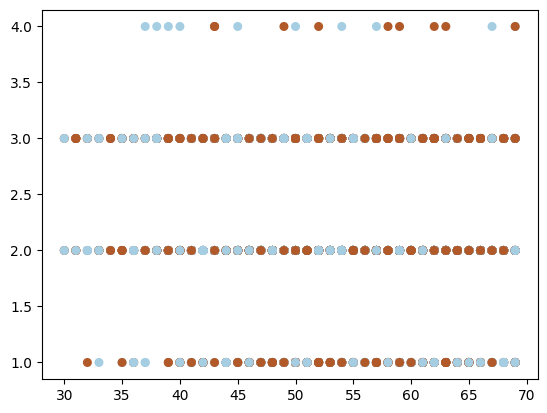

In [9]:
from sklearn.metrics import accuracy_score

svm_ls1 = SVM_Linear_Scratch(C=1)
svm_ls1.fit(X.to_numpy(), y.to_numpy())
pred_ls1 = svm_ls1.predict(X)
print('Accuracy:', accuracy_score(y.to_numpy(), pred_ls1))

plot_decision_support_vectors(svm_ls1, X.to_numpy(), y.to_numpy(), title='Linear SVM form scratch C=1')